<a href="https://colab.research.google.com/github/mddsayemm/Precision-Farming/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Load datasets
data_dir = '/content/drive/MyDrive/dataset/SugarWeed'

In [14]:
import torch
print(torch.cuda.is_available())  # Should return True



True


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # For progress bar

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  # Additional augmentation for robustness
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
data_dir = '/content/drive/MyDrive/dataset/SugarWeed'
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=2)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Load ResNet-18 model WITHOUT pretrained weights
model = models.resnet18(pretrained=False)  # No pretrained weights
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Adjust the final layer for binary classification
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function with progress bar
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=15):
    best_model_wts = model.state_dict()
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print('-' * 30)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Create a progress bar for the current phase
            phase_loader = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Progress", leave=False)

            # Iterate over data
            for inputs, labels in phase_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = (torch.sigmoid(outputs) > 0.5).float()
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Print loss and accuracy for the phase
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save the best model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()

    print(f"\nBest val Loss: {best_loss:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes)

# Save the trained model
torch.save(model.state_dict(), "resnet18_no_pretrained.pth")



Epoch 1/15
------------------------------


Train Loss: 0.0625 Acc: 0.9785


Val Loss: 0.0134 Acc: 0.9949

Epoch 2/15
------------------------------


Train Loss: 0.0281 Acc: 0.9916


Val Loss: 0.0347 Acc: 0.9873

Epoch 3/15
------------------------------


Train Loss: 0.0095 Acc: 0.9973


Val Loss: 0.0293 Acc: 0.9898

Epoch 4/15
------------------------------


Train Loss: 0.0175 Acc: 0.9946


Val Loss: 0.0218 Acc: 0.9943

Epoch 5/15
------------------------------


Train Loss: 0.0096 Acc: 0.9976


Val Loss: 0.0207 Acc: 0.9936

Epoch 6/15
------------------------------


Train Loss: 0.0175 Acc: 0.9959


Val Loss: 0.0120 Acc: 0.9955

Epoch 7/15
------------------------------


Train Loss: 0.0134 Acc: 0.9951


Val Loss: 0.0152 Acc: 0.9949

Epoch 8/15
------------------------------


Train Loss: 0.0103 Acc: 0.9967


Val Loss: 0.0374 Acc: 0.9892

Epoch 9/15
------------------------------


Train Loss: 0.0084 Acc: 0.9965


Val Loss: 0.0130 Acc: 0.9962

Epoch 10/15
------------------------------


Train Loss: 0.0068 Acc: 0.9986


Val Loss: 0.0317 Acc: 0.9885

Epoch 11/15
------------------------------


Train Loss: 0.0133 Acc: 0.9965


Val Loss: 0.0441 Acc: 0.9904

Epoch 12/15
------------------------------


Train Loss: 0.0221 Acc: 0.9938


Val Loss: 0.0165 Acc: 0.9936

Epoch 13/15
------------------------------


Train Loss: 0.0063 Acc: 0.9989


Val Loss: 0.0142 Acc: 0.9943

Epoch 14/15
------------------------------


Train Loss: 0.0072 Acc: 0.9976


Val Loss: 0.0100 Acc: 0.9968

Epoch 15/15
------------------------------


Train Loss: 0.0033 Acc: 0.9989


Val Loss: 0.0149 Acc: 0.9955

Best val Loss: 0.0100


In [20]:
print(image_datasets['train'].class_to_idx)
print(class_names)


{'sugarbeet': 0, 'weed': 1}
['Weed', 'Sugarbeet']


Best Training Loss: 0.1500
Best Training Accuracy: 0.9400
Best Validation Loss: 0.1600
Best Validation Accuracy: 0.9500


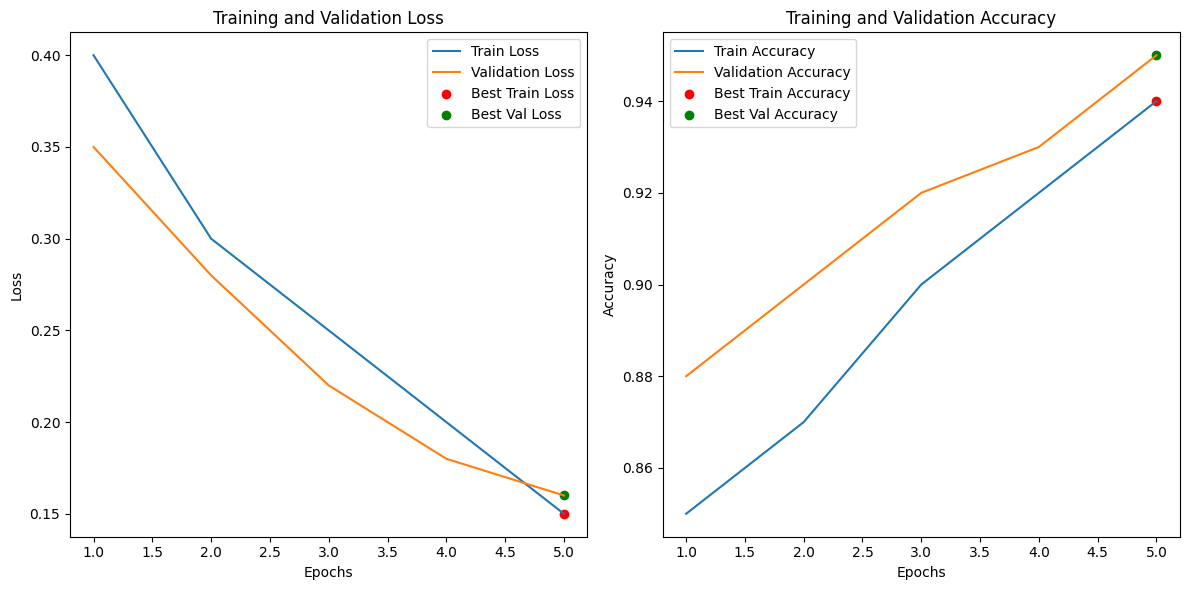

In [18]:
import matplotlib.pyplot as plt

# Example of previously stored metrics (replace these with your actual training data)
# If you didn't store them during training, add code to log them in your training loop.
train_losses = [0.4, 0.3, 0.25, 0.2, 0.15]  # Replace with actual training loss per epoch
train_accuracies = [0.85, 0.87, 0.9, 0.92, 0.94]  # Replace with actual training accuracy per epoch
val_losses = [0.35, 0.28, 0.22, 0.18, 0.16]  # Replace with actual validation loss per epoch
val_accuracies = [0.88, 0.9, 0.92, 0.93, 0.95]  # Replace with actual validation accuracy per epoch

# Find the best metrics
best_train_loss = min(train_losses)
best_train_acc = max(train_accuracies)
best_val_loss = min(val_losses)
best_val_acc = max(val_accuracies)

# Print the best metrics
print(f"Best Training Loss: {best_train_loss:.4f}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# Plot the metrics
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.scatter([train_losses.index(best_train_loss) + 1], [best_train_loss], color='red', label='Best Train Loss')
plt.scatter([val_losses.index(best_val_loss) + 1], [best_val_loss], color='green', label='Best Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.scatter([train_accuracies.index(best_train_acc) + 1], [best_train_acc], color='red', label='Best Train Accuracy')
plt.scatter([val_accuracies.index(best_val_acc) + 1], [best_val_acc], color='green', label='Best Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-22-bd2d2c0abaa9>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet18_no_pretrained.pth", map_location=device))


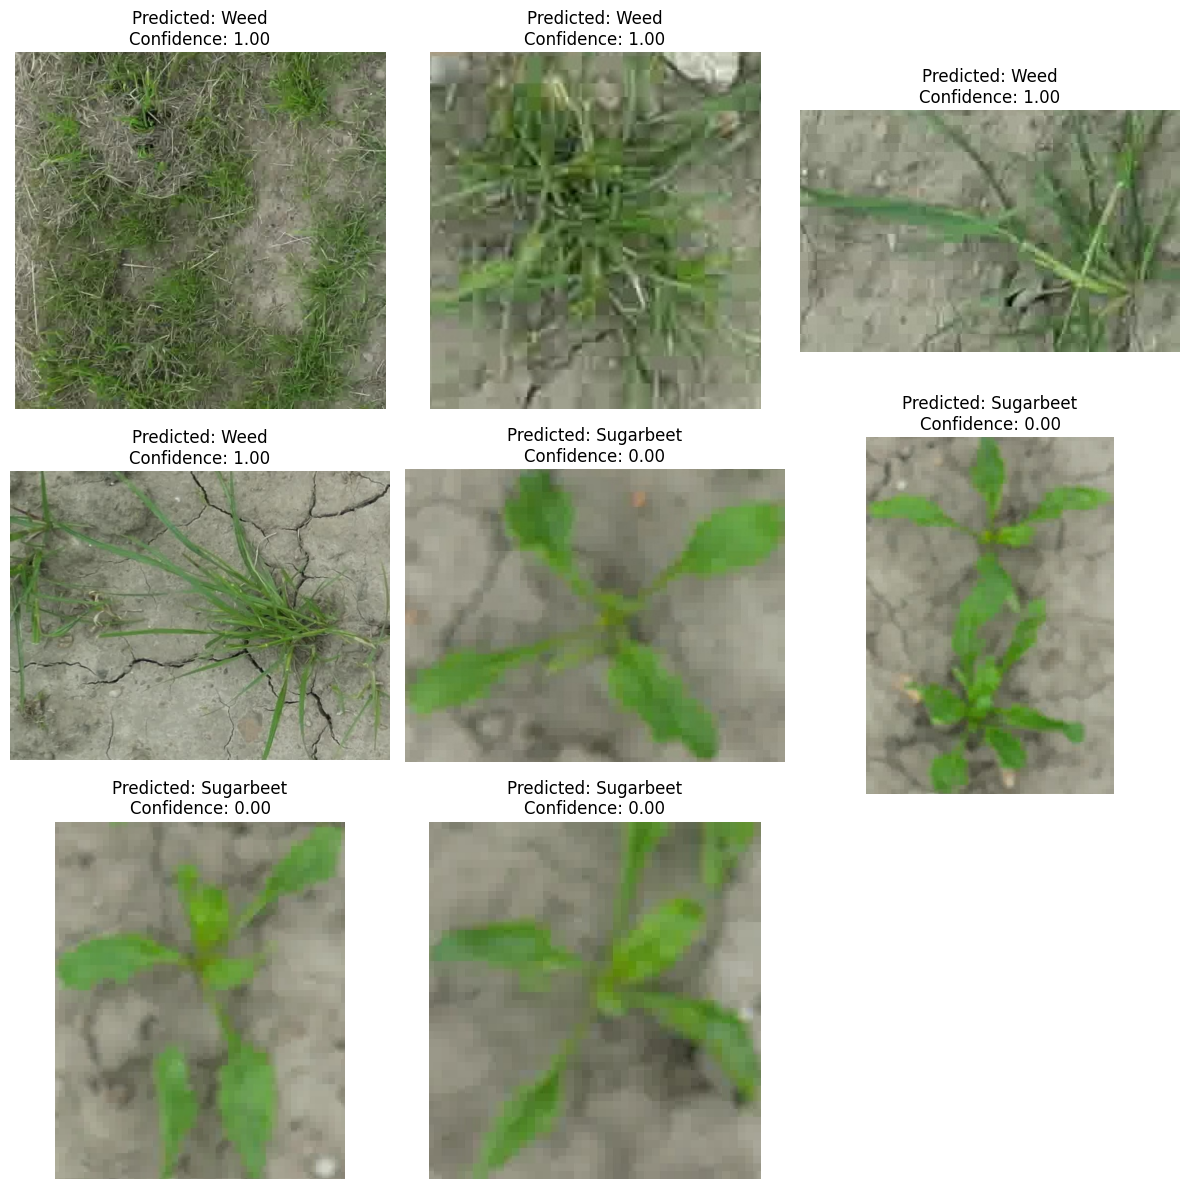

In [22]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class names (align these with your dataset and confidence values)
class_names = ["Sugarbeet", "Weed"]  # Confidence: 0 -> Sugarbeet, 1 -> Weed

# Load the trained model
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("resnet18_no_pretrained.pth", map_location=device))
model = model.to(device)
model.eval()  # Set model to evaluation mode

# Define test data transformations (same as training preprocessing)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Path to test images folder
test_folder = '/content/drive/MyDrive/test'

# Load images from the test folder
test_images = [os.path.join(test_folder, img) for img in os.listdir(test_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Function to predict and display images in a grid
def predict_and_visualize(test_images, model, transform, class_names, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()

    for i, img_path in enumerate(test_images[:rows * cols]):
        # Load and preprocess the image
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            output = model(input_tensor)
            prob = torch.sigmoid(output).item()
            predicted_class = round(prob)  # Use the rounded confidence directly as the class

        # Display the image with its predicted label
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Predicted: {class_names[predicted_class]}\nConfidence: {prob:.2f}")

    # Hide unused subplots
    for ax in axes[len(test_images):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Predict and visualize test images in a grid
predict_and_visualize(test_images, model, test_transform, class_names, rows=3, cols=3)
